In [1]:
pickle_rel_path = '../datasets/notmnist/notMNIST.pickle'
import os
import math
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops

run = 0

### Import data

In [2]:
# Discover pickle path
file_dir = os.path.dirname(os.path.realpath('__file__'))
pickle_path = os.path.abspath(os.path.join(file_dir, pickle_rel_path))
print('Pickle location:',pickle_path)

# Load pickle
with open(pickle_path,'rb') as file:
    datasets = pickle.load(file)
print(datasets.keys())

# Set variables
train_dataset = datasets['train_dataset']
orig_train_labels = datasets['train_labels'] 
validate_dataset = datasets['valid_dataset']
orig_validate_labels = datasets['valid_labels'] 
test_dataset = datasets['test_dataset']
orig_test_labels = datasets['test_labels'] 

# Convert representation
sample_width = train_dataset.shape[2]
sample_height = train_dataset.shape[1]
features_shape = [sample_height,sample_width,1]
num_labels = 10
def setup_xy(samples,labels):
    x = samples.reshape(np.append([-1],features_shape));
    y = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return (x,y)
train_dataset,train_labels = setup_xy(datasets['train_dataset'],datasets['train_labels'])
validate_dataset,validate_labels = setup_xy(datasets['valid_dataset'],datasets['valid_labels'])
test_dataset,test_labels = setup_xy(datasets['test_dataset'],datasets['test_labels'])

Pickle location: C:\Users\lgess\Documents\repo\learning_ai\datasets\notmnist\notMNIST.pickle
dict_keys(['valid_labels', 'test_labels', 'train_dataset', 'valid_dataset', 'train_labels', 'test_dataset'])


### Normalize data

Pre-normalized

### Define model

In [82]:
class Layer: 
    
    # Todo: add with tf.name_scope(self.name):
    
    def __init__(self, name, features_shape):
        self.name, self.features_shape = name, features_shape
        self.w, self.b = None, None
        
    def create_vars(self):
        with tf.name_scope(self.name):
            w_shape, b_shape = self.wb_shapes()
            initializer = tf.glorot_normal_initializer()
            if not w_shape is None:
                self.w = tf.get_variable(name="W"+self.name, shape=w_shape, 
                                         dtype=tf.float32, initializer=initializer)
            if not b_shape is None:    
                self.b = tf.get_variable(name="B"+self.name, shape=b_shape, 
                                         dtype=tf.float32, initializer=initializer)
    
    def inference(self, x):
        with tf.name_scope(self.name):
            return self._inference(x)
            
    def training(self, x, y, keep_prob):
        with tf.name_scope(self.name):
            return self._training(x, y, keep_prob)
    
    def wb_shapes(self):
        raise NotImplementedError()
        
    def out_features_shape(self):
        raise NotImplementedError() 
            
    def _inference(self, x):
        raise NotImplementedError() 
            
    def _training(self, x, y, keep_prob):
        raise NotImplementedError() 
        
class InputLayer(Layer):           
        
    def __init__(self, layerNum, features_shape):
        name = str(layerNum)+"In"
        super().__init__(name, features_shape)    
        
    def wb_shapes(self):
        return (None, None)
        
    def out_features_shape(self):
        return features_shape
        
    def _inference(self, x):
        return x
            
    def _training(self, x, y, keep_prob):
        return x
        
class FlattenLayer(Layer): # Flattens x into [num_samples,-1]            
        
    def __init__(self, layerNum, features_shape):
        name = str(layerNum)+"Flat"
        super().__init__(name, features_shape)    
        
    def wb_shapes(self):
        return (None, None)
        
    def out_features_shape(self):
        return [np.prod(self.features_shape)]
        
    def _inference(self, x):
        out_features_num = self.out_features_shape()[0]
        return tf.reshape(x, [-1, out_features_num])
            
    def _training(self, x, y, keep_prob):
        return self._inference(x)

class TradHiddenLayer(Layer): 
    
    # TODO accept generic shape by using tensordot? (less performance?)
    
    def __init__(self, layerNum, features_shape, neurons):
        name = str(layerNum)+"Relu"
        super().__init__(name, features_shape)
        self.neurons = neurons
        
    def wb_shapes(self):
        return ( np.append(self.features_shape,[self.neurons]), [self.neurons] )
        
    def out_features_shape(self):
        return [self.neurons]
            
    def _inference(self, x): 
        z = tf.matmul(x, self.w)+self.b 
        return tf.nn.relu(z)
            
    def _training(self, x, y, keep_prob):
        if keep_prob<1:
            x = tf.nn.dropout(x, keep_prob)
        return self._inference(x)
        
class ConvHiddenLayer(Layer):      
    
    # TODO different dropout for conv?
        
    def __init__(self, layerNum, features_shape, kernel_size, depth, stride_size, padding):
        name = str(layerNum)+"Conv"
        super().__init__(name, features_shape)
        self.kernel_size = kernel_size; self.depth = depth
        self.stride_size = stride_size; self.padding = padding
            
    def wb_shapes(self):
        return ( [self.kernel_size,self.kernel_size,self.features_shape[-1],self.depth], [self.depth] )
        
    def out_features_shape(self):
        if self.padding == "SAME":
            return [math.floor(self.features_shape[0]/self.stride_size),
                    math.floor(self.features_shape[1]/self.stride_size),
                    self.depth]
        else:
            return [math.floor((self.features_shape[0]-self.kernel_size)/self.stride_size) +1,
                    math.floor((self.features_shape[1]-self.kernel_size)/self.stride_size) +1,
                    self.depth]
            
    def _inference(self, x):
        conv = tf.nn.conv2d(input=x, filter=self.w, padding=self.padding,
                            strides=[1,self.stride_size,self.stride_size,1] )
        return tf.nn.relu(conv+self.b)
            
    def _training(self, x, y, keep_prob): 
        if keep_prob<1:
            x = tf.nn.dropout(x, keep_prob)
        return self._inference(x)
                          
class OutputLayer(TradHiddenLayer):
    
    # TODO accept generic shape by using tensordot? (less performance?)
    # TODO Should have dropout?
    
    def __init__(self, layerNum, features_shape, num_labels):
        name = str(layerNum)+"SMax"
        super().__init__(name, features_shape, num_labels)
            
    def _inference(self, x):
        z = tf.matmul(x, self.w)+self.b 
        return tf.nn.softmax(z)
                             
    def _training(self, x, y, keep_prob):          
        z = tf.matmul(x, self.w)+self.b 
        return tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=z, labels=y))
            
        
class Model:
                          
    def __init__(self, layers):
        self.layers = layers   
        
    def create_vars(self):
        for layer in self.layers:
            layer.create_vars()
                          
    def inference(self, x):
        with tf.name_scope("Inference"):
            for layer in self.layers:
                x = layer.inference(x)
            return x
                          
    def loss(self, x, y, keep_prob, regularization):
        l2 = 0
        with tf.name_scope("Loss"):
            for layer in self.layers:
                x = layer.training(x, y, keep_prob)
                if (not layer.w is None) and (regularization > 0):
                    l2 = l2 + tf.nn.l2_loss(layer.w)/tf.cast(tf.size(layer.w),tf.float32)
            return x + regularization*l2
        
    def training_step(self, x, y, learning_rate, keep_prob, regularization):
        with tf.name_scope("TrainingStep"):
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
            loss = self.loss(x, y, keep_prob, regularization)
            tf.summary.scalar('loss', loss)
            return optimizer.minimize(loss)
    
class SessionRunner:
    
    # TODO stop when validation loss stops to grow
    
    def __init__(self, model, run):
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            
            self.model = model
            self.session = tf.Session()
            self.log_writer = tf.summary.FileWriter("/tf_log/"+str(run), self.graph)
            
            self.x = tf.placeholder(dtype=tf.float32,shape=np.append(None,features_shape), name="x")
            self.y = tf.placeholder(dtype=tf.float32,shape=np.append(None,[num_labels]), name="y")
                        
            model.create_vars() 
            self.inference = model.inference(self.x)

    def train(self, train_dataset, train_labels, batch_size=200, iterations=1000,
              learning_rate=0.5, keep_prob=1, regularization=0):
        
        index = 0
        num_data = len(train_dataset)
        if batch_size > num_data:
            batch_size = num_data
        
        with self.graph.as_default():            
            
            init = tf.global_variables_initializer()
            step_op = model.training_step(self.x, self.y, learning_rate, keep_prob, regularization)
            summary_op = tf.summary.merge_all()
        
        self.session.run(init)
        
        for i in range(iterations):   
            if 2*batch_size < num_data:
                index = (i*batch_size)%(len(train_dataset)-batch_size)
            feed_dict={self.x: train_dataset[index:index+batch_size], 
                       self.y: train_labels[index:index+batch_size]}      
            _,summary = self.session.run([step_op, summary_op], feed_dict)
            self.log_writer.add_summary(summary, i)
        print("done")
                
    def predict(self, dataset):
        return self.session.run(self.inference, feed_dict={self.x: dataset})
        
    def evaluate(self, dataset, labels):
        print(self.__accuracy(predicted=self.predict(dataset), expected=labels))
        
    def __accuracy(self, predicted, expected):
        return np.mean(np.argmax(predicted,1) == np.argmax(expected,1))
         
    


In [134]:
def create_classifier(features_shape, num_labels):
                            
    layers = []; layer_num = 0;
    num_features = np.prod(features_shape)
    
    # InputLayer
    layer = InputLayer(layer_num, features_shape)
    layers.append(layer); layer_num+=1
    # ConvHiddenLayer
    layer = ConvHiddenLayer(layer_num, layer.out_features_shape(), 
                            kernel_size=7, depth=16, stride_size=1, padding="VALID")
    layers.append(layer); layer_num+=1
    # ConvHiddenLayer
    layer = ConvHiddenLayer(layer_num, layer.out_features_shape(), 
                            kernel_size=7, depth=32, stride_size=1, padding="VALID")
    layers.append(layer); layer_num+=1
    # FlattenLayer
    layer = FlattenLayer(layer_num, layer.out_features_shape())
    layers.append(layer); layer_num+=1
    # TradHiddenLayer
    layer = TradHiddenLayer(layer_num, layer.out_features_shape(), neurons=64)
    layers.append(layer); layer_num+=1
    # TradHiddenLayer
    layer = TradHiddenLayer(layer_num, layer.out_features_shape(), neurons=64)
    layers.append(layer); layer_num+=1
    # OutputLayer
    layer = OutputLayer(layer_num, layer.out_features_shape(), num_labels)
    layers.append(layer); 

    return Model(layers=layers)


### Train model

In [135]:
try:
    session_runner.session.close()
except:
    None
    
model = create_classifier(features_shape, num_labels)
session_runner = SessionRunner(model, run); num_t_samples = 200000

run += 1
session_runner.train(train_dataset[0:num_t_samples], train_labels[0:num_t_samples], 
                     batch_size=30, iterations=5000, 
                     learning_rate=0.05, keep_prob=1, regularization=0)

done


### Evaluate Model

In [136]:
num_t_samples = 25000
#session_runner.evaluate(train_dataset[0:num_t_samples], train_labels[0:num_t_samples])
session_runner.evaluate(validate_dataset, validate_labels)
session_runner.evaluate(test_dataset, test_labels)

0.8716
0.9379


### Test sample

Label: 3


3

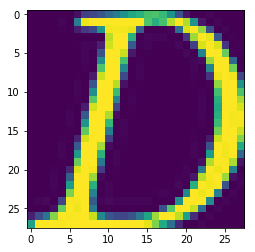

In [132]:
def show_sample(sample_image, label):
    plt.figure()
    plt.imshow(sample_image)
    print('Label:', np.argmax(label))

index=0
show_sample(validate_dataset[index].reshape(features_shape[0:2]),validate_labels[index])
np.argmax(session_runner.predict([validate_dataset[index]]))